# Python data analysis script Version 1.0

This script takes `.json` files exported from the `[JSONWriter]` module of Corryvreckan, and is aimed towards analyzing and plotting the hit data.

## Importing data into python

### Reading in .json file

In [3]:
import json
import os

import hit_data_unaligned as Data

hit_data = Data.hit_data

ModuleNotFoundError: No module named 'hit_data_unaligned'

In the tutorial notebook the data was processed and stored in a handy library, which we will use now to look at the data

## Taking a first look at the data

We will be using the `mplot3d` toolkit from `matplotlib` to visualize the data. First we import it:

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import proj3d
%matplotlib notebook

Next we choose what data to plot, and how we want it to look like

In [2]:
ppx, ppy = 0.02924, 0.02688 #Pixel pitches in x and y [mm]
plot_tracks = 3             #Plot the first 3 events
connect_hits = True         #Connects the hits
min_nop = 7                 #Plot only events that include 7 planes

#Create a figure object
xlim,ylim,zlim = 1023*ppx,511*ppy,6*20 #Dimensions of the detector
fig = plt.figure(figsize=(5,5))
ax = plt.axes(projection='3d')  #Create 3d Axes
ax._axis3don = False            #... but invisible
#ax.set_box_aspect((3,3,3))      #Define aspect ratio
ax.set_xlim3d(0,xlim)           #Axis limits in x
ax.set_ylim3d(0,ylim)           #Axis limits in y
ax.set_zlim3d(0,zlim)     
x = np.arange(0,1025*0.02924,512*0.02924)
y = np.arange(0,1024*0.02688,512*0.02688)
X, Y = np.meshgrid(x,y)
Z = np.ndarray((len(y),len(x)))
Z.fill(0)

#Draw the planes
for plane in range(7):
    Z.fill(plane*20)
    ax.plot_surface(X,Y,Z,alpha=.1,color='black')

plot_counter = 0
#Plot the hits
for event in range(len(hit_data)):
    
    #Plot only events with the minimum amount of planes specified
    if (hit_data[event]['number_of_planes'] < min_nop): continue
        
    x_data, y_data, z_data = [], [], []
    
    for plane in range(7):
        
        #Skip over empty hits
        if (hit_data[event][plane]["XC"] == -1): continue
        
        #Put everything else into plottable arrays
        x_data.append(ppx*hit_data[event][plane]["XC"])
        y_data.append(ppy*hit_data[event][plane]["YC"])
        z_data.append(plane*20)

        ax.scatter3D(x_data,y_data,z_data,alpha=.7,color='black',marker='.')
        
        # OPTIONAL: Connect dots for Better visibility of Tracks
        if connect_hits:
            ax.plot(x_data,y_data,z_data, linewidth=.5)#, color='grey')
        
    plot_counter+=1
    if plot_counter > plot_tracks: break
    

NameError: name 'plt' is not defined

## Next steps

Next, the processed data is used to get a nice overview over some properties of the data. 
First, the number of events and the event quality is examined. We look at:
- the number n of firing detector planes in each event (n-plane-event)
- the number of hits, each plane registered
- the number of events with "holes". This means events, where the sequence of firing planes is not consecutive (e.g.: [1,2,5,6] instead of [1,2,3,4,5,6]) 

In [ ]:
# container
holes=[[0,0,0,0,0,0,0],[0,0,0,0,0,0,0],[0,0,0,0,0,0,0]]#holes[number of holes][n-plane-event], 
#e.g. holes[0][5] = number of 6-plane-events with 1 hole

holes_sum = [0,0,0,0,0,0,0] # number of n-plane-events, with at least 1 hole
#e.g. holes_sum[3] = number of 4-plane-events with at least 1 hole

n_p_e = [0,0,0,0,0,0,0] #number of n-plane-events (events in which n planes fired)
hits = [0,0,0,0,0,0,0] #number of hits per plane

#definition to exclude zeros from start and beginning of a list.
#Important, since for an event with the planes [2,3,5,6] we don't assign plane 0 and 1 as holes, but we do for plane 4.
def clear_seq(list):
    #check for value 1 in the last entry of the list
    while list[-1] == 1:
        list.pop(-1) #discard this entry from the list: [0,0,1] -> [0,0]
        
    #check for value 1 in the first entry of the list
    while list[0] == 1:
        list.pop(0)  #discard this entry from the list: [1,0,0] -> [0,0]

#loop over every event in hit_data
for event in range(len(hit_data)):

    ### count number of n-plane-events and the number of hits per plane (fill the corresponding container)
    n_p_e[hit_data[event]["number_of_planes"]-1] +=1
    #check which planes fired
    for i in range(7):
        #empty planes (without hits) are filled with a -1, so we check here, which planes of an event are not empty
        if hit_data[event][i]["XC"] != -1:
            hits[i] +=1
        

    ### count the holes total (depending on the number of involved planes)

    # look in events with number >=2 of involved planes (n-plane-events), since otherwise no "holes" are possible
    if hit_data[event]["number_of_planes"] >= 2:

        npe = hit_data[event]["number_of_planes"]# npe is now the number of firing planes in the selected event
        seq=[0,0,0,0,0,0,0]
        # look through every plane, if there is a hole
        for i in range(7):
            #-1 signs a plane without a hit in hit_data
            if hit_data[event][i]["XC"] == -1:
                #now a hole is marked as 1 in the sequence 
                seq[i]= 1
        #clear holes from the beginning and end of the sequence, e.g. [1,0,1,0,0,0,1] -> [0,1,0,0,0]
        clear_seq(seq)
        # now the number of empty planes (=holes) corresponds to the sum over the array seq.
        num_holes = sum(seq)

        #NOW: fill the container holes and holes_sum
        # if at least one hole is there
        if num_holes > 0:
            #increase total number of holes of an event with n planes (index n-1)
            holes_sum[npe-1] +=1
            if num_holes == 1:
                #increase number of 1-hole-events with n planes (index n-1)
                holes[0][npe-1] += 1
            elif num_holes == 2:
                #increase number of 2-hole-events with n planes (index n-1)
                holes[1][npe-1] += 1
            elif num_holes == 3:
                #increase number of 3-hole-events with n planes (index n-1)
                holes[2][npe-1] += 1


Now we plot the results:

In [ ]:
plane = np.arange(1, 8)  #index of the number of traversed planes fot the plots
n_p_e = np.array(n_p_e)  # converting list to np.array

# plotting n-plane-events
plt.figure()
plt.yscale("log")
plt.grid(which="both", axis="both")
plt.errorbar(plane, n_p_e, xerr=0.5, fmt='k', elinewidth=1.5, lw=0, capsize=3, capthick=1.5)
plt.xlabel("Number of traversed planes")
plt.ylabel("Number of events")
plt.title("Number of measured measured multi-plane-events")
plt.tick_params(axis='both')
#plt.legend()
plt.show()

In the plot above, the measured events are shown seperately according to the number of firing planes of the event (with at least 2 planes).

The distribution shows a decreasing number of events for increasing number of traversed planes, which is expected. To make a more specific statement we can compare the distribution to another measurment:
In the plot below the expected distribution (with the measured distribution from an older data acquisition) is shown from the Bachelor thesis of David Schledewitz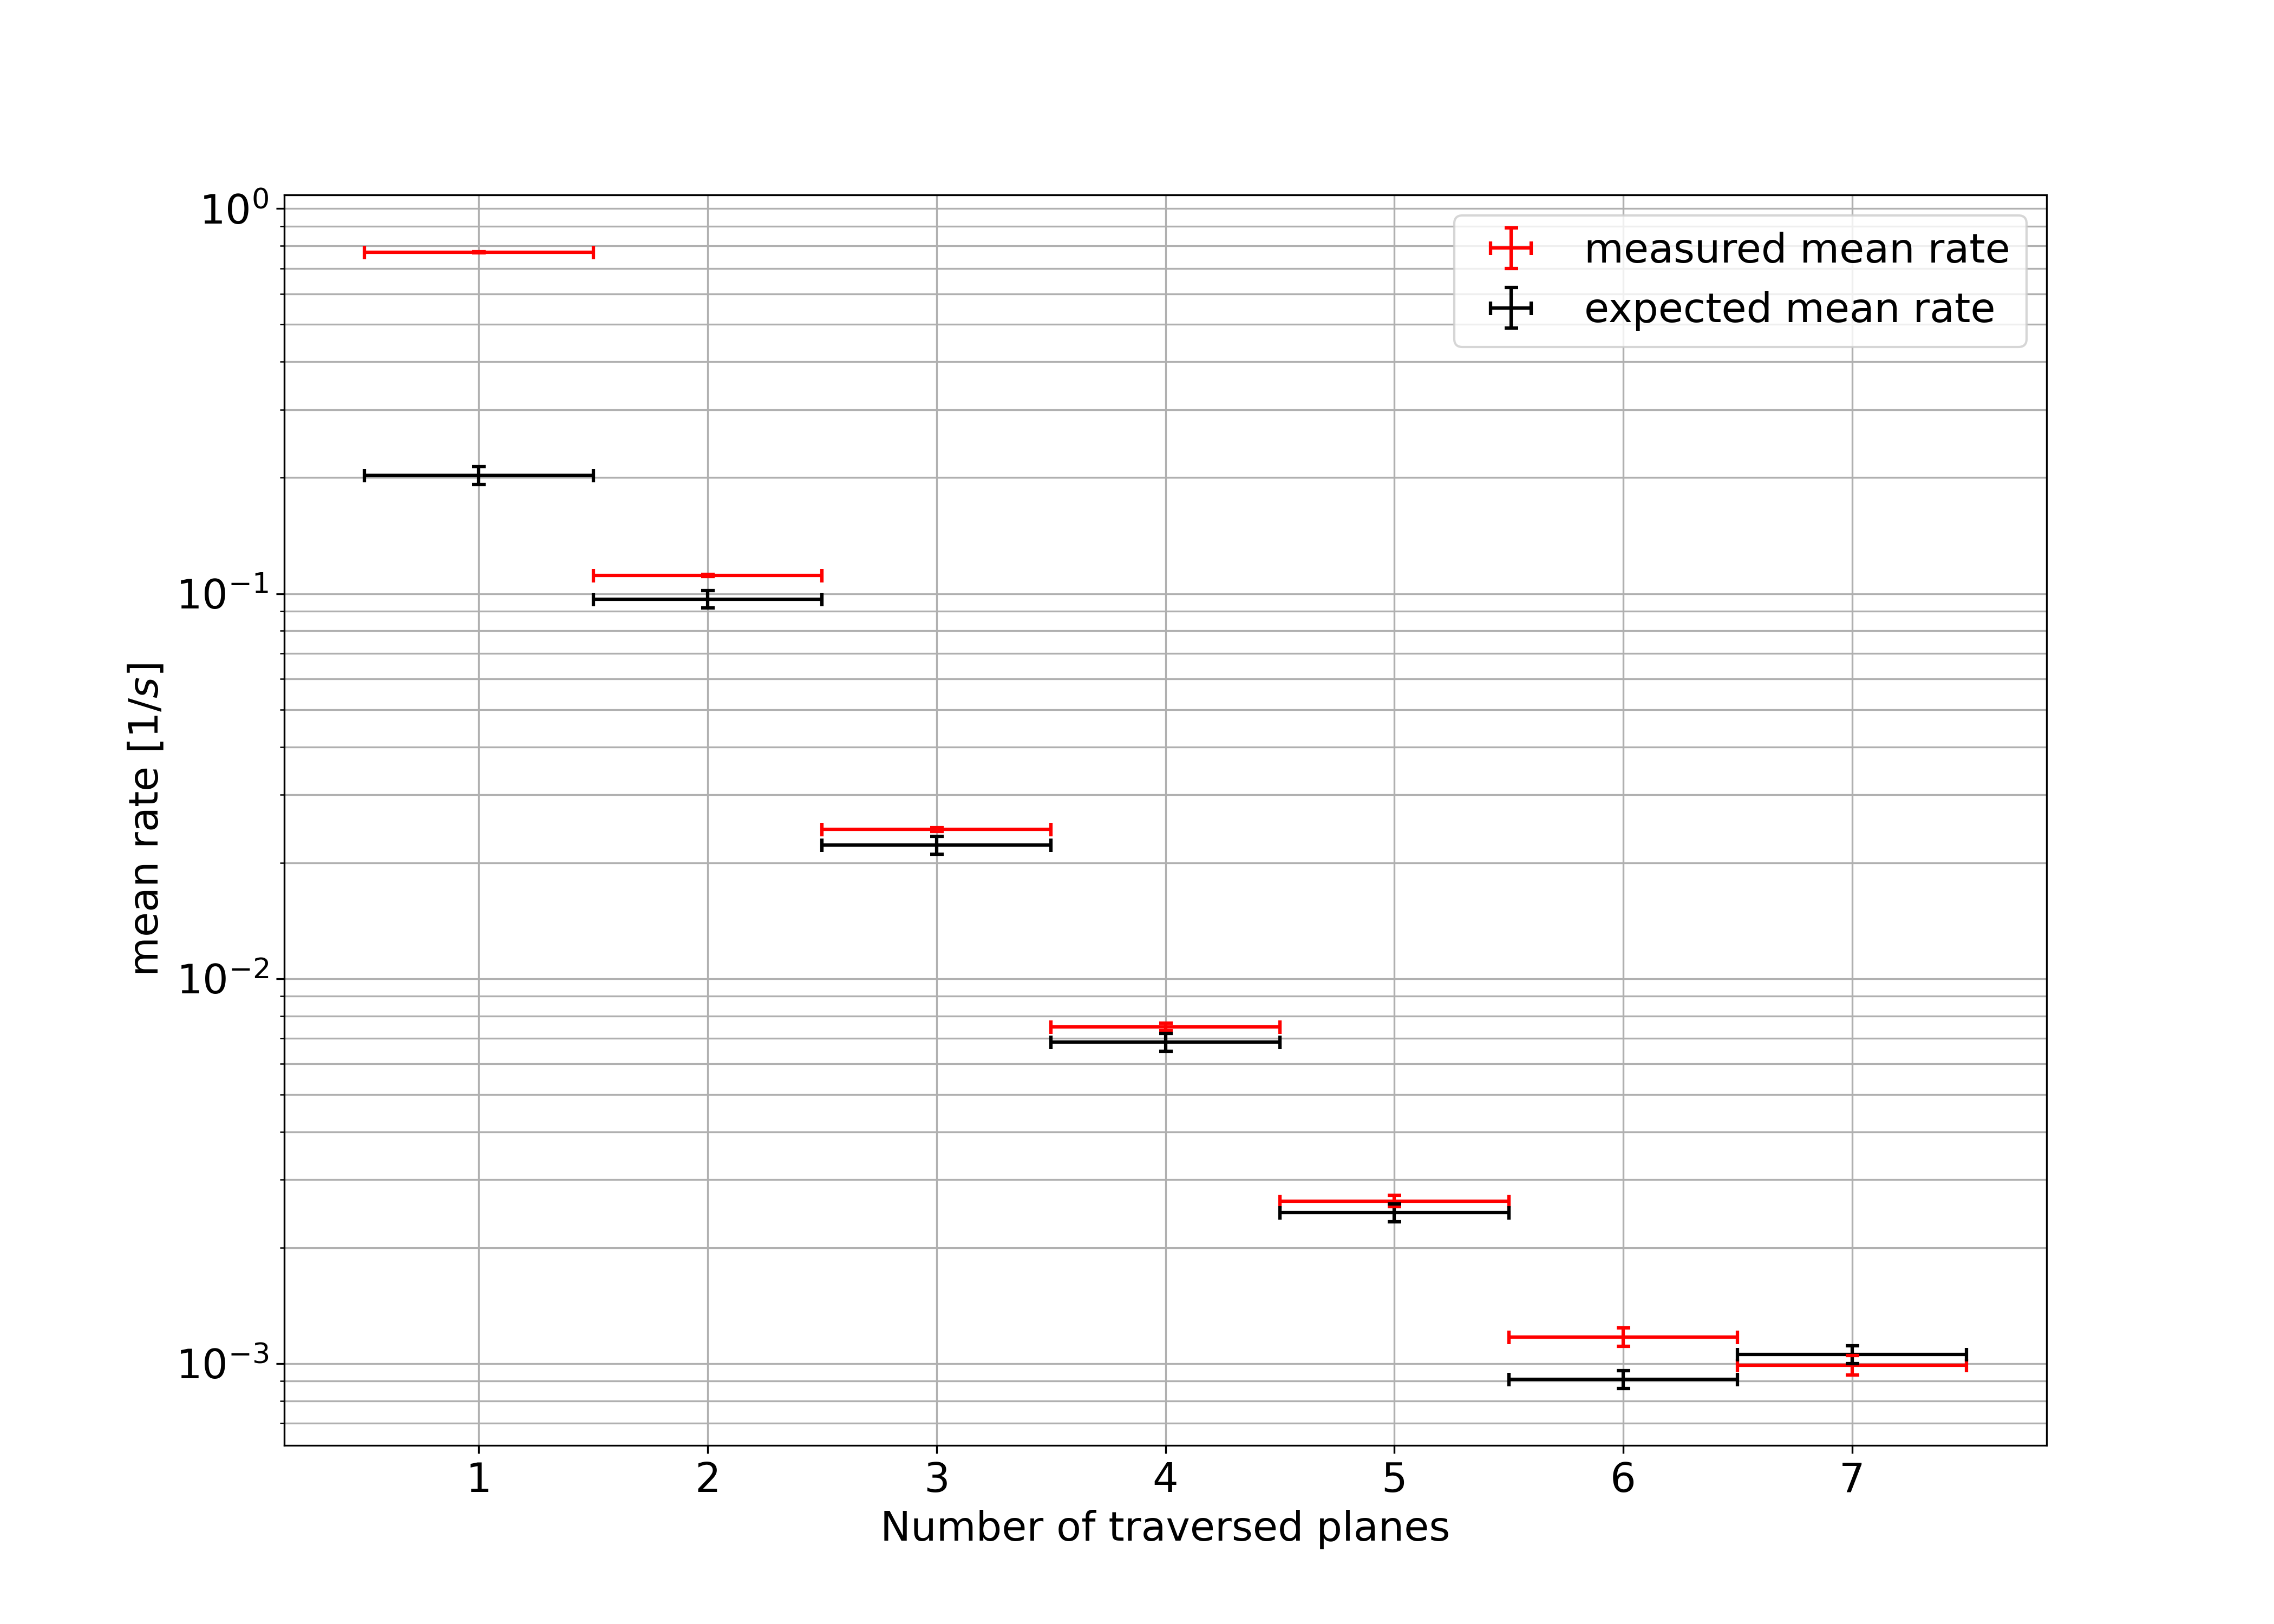

By comparing these plots we can already see from the naked eye that the data does not fit the expectation too well, since the gap between 2- and 3-plane-events is significantly larger in the upper plot.

But this data is not "cleaned up" yet. That means it does not show the correct distribution, as many not consecutive events are still included. 

We look at them in the next plots:

In [ ]:
# plotting sum of holes and n-plane-events in plot 1
# plotting ratio of events with gaps to total number of n-plane-events in plot 2
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10, 4))
ax1.set_yscale("log")
ax1.grid(which="both", axis="both")
ax1.errorbar(plane, n_p_e,xerr=0.5, fmt='k',elinewidth=1.5, lw=0, capsize=5, capthick=1.5, label= "Measured number of n-p-e")
ax1.errorbar(plane, holes_sum,xerr=0.5, fmt='b', elinewidth=1.5, lw=0, capsize=3, capthick=1.5, label= "Number of events with gaps")

ax1.set_xlabel("number of traversed planes")
ax1.set_ylabel("mean rate $[1/s]$" )
ax1.tick_params(axis='both')
#ax1.set_title("Mean rate of measured multi-plane-events, considering holes")
ax1.legend()#(fontsize=16)

ax2.errorbar(plane, holes_sum/(n_p_e+0.00000000001), xerr=0.5,fmt='k',
             elinewidth=1.5, lw=0, capsize=3, capthick=1.5)#+0.00000000001 quick fix to avoid divsion by zero
ax2.grid(which="both", axis="both")
ax2.set_xlabel("number of traversed planes" )
ax2.set_ylabel("Ratio of events with gaps to all measured events" )
ax2.tick_params(axis='both')
#ax2.set_title("Ratio of events with gaps to total rate of n-plane-events")
plt.show()

Left we see the total number of evenets compared to the number of events with holes. Right we see the ratio of the events with holes over the total number of events.

It is clear to see that most events with 2,3,4 or 5 traveresed planes have a hole. Looking in a sample of 5-plane-events, we can see that a hot pixel/column, which is firing all the time, might be the reason:

In [ ]:
#PLANE:
0
1
2
3
4
5
6
################### 
# 5-plane-events, columns (center of gravity), -1: empty
###################
-1.0
"591.0"
-1.0
944.33
652.0
635.0
533.0
###################
-1.0
"591.0"
-1.0
959.0
690.0
771.5
718.0
###################
-1.0
"591.0"
-1.0
390.0
"506.0"
886.0
747.5
###################
219.0
416.0
333.5
436.5
"506.0"
-1.0
-1.0
###################
-1.0
"591.0"
-1.0
390.0
"506.0"
174.5
260.8
###################
"Sequence of some 5-plane-events"

As seen in the data sample, in most events the same column of plane 1 has fired, which indicates a hot pixel/coulumn.

Also interesting, regarding to the holes, is to look at how many gaps are in between a consecutive sequence of firing planes. Are not consecutive sequences looking like [1,2,4,5] or like [1,3,5] or [1,5]? If we look at the plot below, we can see that in most cases of 2-plane events and 4-plane-events 2 holes are in the sequence, while in most 3-plane-events with holes, only 1 hole is appearent.

Looking at the data sample above again, plane 4 shows also the same coulumn in more than one event, which could explain the observations of 2- and 4-plane-events of the plot below (in combination with the hot column in plane 1).

In [ ]:
# plotting events with holes, dependent on the number of holes in an event
plt.figure()
plt.grid(which="both", axis="both")
#sum
plt.errorbar(plane[1:6], holes_sum[1:6], xerr=0.5,fmt='k', elinewidth=1.5, lw=0, capsize=6, capthick=1.5, label= "Total number of holes")
#1 hole events
plt.errorbar(plane[1:6], holes[0][1:6],xerr=0.5,fmt='r',elinewidth=1.5, lw=0, capsize=3, capthick=1.5, label= "number of 1 hole events")
#2 hole events
plt.errorbar(plane[1:6], holes[1][1:6],xerr=0.5, fmt='b',elinewidth=1.5, lw=0, capsize=3, capthick=1.5, label= "number of 2 hole events")
#3 hole events
plt.errorbar(plane[1:6],holes[2][1:6], xerr=0.5,fmt='green',elinewidth=1.5,lw=0,capsize=3, capthick=1.5, label= "number of 3 hole events")

plt.xlabel("number of traversed planes")
plt.ylabel("Number of holes")
plt.title("Number of holes")
plt.legend()
plt.show()

Another piece of evidence for this assumption can be found in the total number of hits per plane, where you can clearly see that plane 1 and 4 are firing at significantly higher rates than the other planes. It is to mention that also plane 3 is firing at a significantly higher rate than plane 0,2,5,and 6. This could explain the number of events with one hole in 3-plane-events in comparison to events with 2 holes, as most probably the planes [1,3,4] are firing often due to a hot pixel/column.

Another observation from the plot below is that the number of events from the planes 0,2,5,6 (which most proably have no hot pixel) increases slightly from from 0 to 6. This can be explained by the trigger system, since only one trigger is installed and placed below plane 6. Therefore it is more likely for a muon, which hits the triggering scintillator to also hit plane 6 as it is to hit plane 0.

In [ ]:
# plotting total number of hits
plt.figure()
plt.grid(which="both", axis="both")
plt.errorbar(plane-1, hits, xerr=0.5, fmt='k',
             elinewidth=1.5, lw=0, capsize=3, capthick=1.5)
plt.xlabel("Plane" )
#plt.ylabel("Mean rate $[1/s]$", )
plt.ylabel("Counts")
plt.tick_params(axis='both')
plt.title("Number of hits per plane")
# plt.legend()
plt.show()

To get a clearer picture of the actual particle tracks and distributions, the data has to be corrected by the hot pixels, either by masking them or by exluding such events with hot pixels.

If this is done, in the next step we can look at the angular distribution of the cosmics. From there, the next task would be to find how the angle of a particle affects the detector response.

## Angular distribution

Now, the angular distribution and fit quality is examined:

In [ ]:
##container to store plot information

# here the incident angles of the events are stored
Phi =  np.array([])
# here the chi^2_red values of the events are stored
Chi2red =  np.array([])
# here the incident angles of the 4-, 5-, 6-, 7-plane-events are stored seperately:
Phi4,Phi5,Phi6,Phi7 = np.array([]),np.array([]),np.array([]),np.array([])

chi2red = 10 ###############   choose chi2red cut for the data visualisation. 
#After looking at the fit quality in relation with the chi2red value, we found a value of 10 as a good indicator for a good track


# select an event(run over all events)
for event in range(len(hit_data)):

    #check that the event has at least 4 involved planes, since these are the most interesting for tracking, and hence further analysis
    if hit_data[event]["number_of_planes"] >= 4:

        #check, if chi2red < 10, to justify that the fit of the track in this event is good
        if hit_data[event]["chi2red"] <= chi2red:

            #save chi2red for good tracks in list
            Chi2red = np.append(Chi2red,hit_data[event]["chi2red"])

            #extract the distances out of the two track points (tp1 and tp2) given. Those are then used to calculate the angle of the track
            d_x = hit_data[event]["tp2"][0]-hit_data[event]["tp1"][0]
            d_y = hit_data[event]["tp2"][1]-hit_data[event]["tp1"][1]
            d_z = hit_data[event]["tp2"][2]-hit_data[event]["tp1"][2]
            d_t = np.sqrt(d_x**2 + d_y**2)

            #calculate angle of the track
            phi = np.arctan(d_t/d_z)*360/(2*np.pi)
            Phi = np.append(Phi,phi)

            # look at the angles for events with different numbers of involved planes
            if hit_data[event]["number_of_planes"]==4:
                Phi4 = np.append(Phi4,phi)
            if hit_data[event]["number_of_planes"]==5:
                Phi5 = np.append(Phi5,phi)
            if hit_data[event]["number_of_planes"]==6:
                Phi6 = np.append(Phi6,phi)
            if hit_data[event]["number_of_planes"]==7:
                Phi7 = np.append(Phi7,phi)


#######################---PLOTS   PLOTS   PLOTS   PLOTS---#############################

plt.hist(Phi,bins= 14 ,range=(0,28), color= "darkblue")#, label="Selected tracks, $\chi^2_{red} \leqslant$ "+str(chi2red))
plt.title("Angular distribution of 4 or more plane events with $\chi^2_{red} \leqslant$ "+str(chi2red))
plt.xlabel("Zenith angle [°]")
plt.ylabel("Counts")
plt.legend()
plt.show()

plt.figure(figsize=(8, 8))
plt.hist(Chi2red, bins=20, color="darkblue")#, label="Selected tracks, $\chi^2_{red}$ in range "+str(chi11)+" to "+str(chi12))+" and "+str(chi21)+" to "+str(chi22)
#plt.hist(Chi,range=(0,100), bins=50, label="Selected tracks, $\phi$ in range "+str(phi111)+" to "+str(phi142))
plt.title("$\chi^2_{red}$-distribution of 4 and more plane events with cut at $\chi^2_{red} =$ "+str(chi2red), fontsize = 24)# in range "+str(chi11)+" to "+str(chi12))
plt.xlabel("$\chi^2_{red}$", fontsize = 18)
plt.ylabel("Counts", fontsize = 18)
plt.tick_params(axis='both', labelsize=18)
#plt.legend()
plt.show()

plt.figure(figsize=(12, 10))
plt.hist(([Phi7,Phi6,Phi5,Phi4]), bins= 14 ,range=(0,28),label=("7 planes","6 or more planes","5 or more planes","4 or more planes" ), color= ("darkred","darkgreen","darkorange","darkblue")
, histtype="barstacked")#, weights=(np.ones(len(Phi7)),np.ones(len(Phi6))/2,np.ones(len(Phi5))/3,np.ones(len(Phi4))/4))
plt.title("Angular distribution of n-plane-eventswith, $\chi^2_{red}\leq$"+str(chi2red), fontsize = 24)#, $\chi^2_{red}$ in range "+str(chi11)+" to "+str(chi12), fontsize = 24)
plt.xlabel("Zenith angle [°]", fontsize = 18)
plt.ylabel("Counts", fontsize = 18)
plt.tick_params(axis='both', labelsize=18)
plt.legend(fontsize = 18)